In [1]:
import pyodbc    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import confusion_matrix,silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Getting Data
## Instead of storing data in a csv file and call it, get data directly from SQL server

In [2]:
serverprop = ("Driver={SQL Server Native Client 11.0};"
            "Server=XYZ;"
            "Database=XYZ;"
            "UID=XYZ;"
            "PWD=XYZ;")
stp = pyodbc.connect(serverprop)

In [3]:
query1=" select Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee,( sum(SalesQty)- sum(ReturnQty)) as NetQty from \
    (SELECT sdf.ccMoshtary as Moshtary,sdf.ccDarkhastFaktor as DarkhastFaktor,wk.TarikhForm as TarikhForm,wkala.CodeMother as Kcode,wks.Gheymat3 as Fee, sum(wks.Tedad3)as SalesQty, 0 as ReturnQty\
     FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm=8 and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3\
    Union All\
    SELECT sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3,0 as SalesQty,sum(wks.Tedad3)as ReturnQty\
    FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm in (10,57) and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3) as kol\
    where TarikhForm between '2022-03-20' and '2022-10-23'\
    group by Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee"


In [4]:
data = pd.read_sql( query1 , stp)

C:\Users\h.nazari\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
#dataset size
data.shape

(811016, 6)

In [6]:
data.head()

,Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee,NetQty
0,81991.0,1170615.0,2022-05-12 10:55:09.487,3481,80400.0,10.0
1,83858.0,1246512.0,2022-08-14 13:02:30.667,3028,459200.0,10.0
2,81701.0,1166649.0,2022-05-08 09:16:16.460,3067,213115.0,40.0
3,93591.0,1191197.0,2022-06-12 16:02:07.420,3500,276000.0,6.0
4,83834.0,1192354.0,2022-06-13 11:13:12.480,3147,246000.0,12.0


In [7]:
data.columns

Index(['Moshtary', 'DarkhastFaktor', 'TarikhForm', 'Kcode', 'Fee', 'NetQty'], dtype='object')

# Features Descriptions

* Moshtary : CustomerID
* DarkhastFaktor : Invoice Number
* TarikhForm : Invoice Date
* Kcode : Product Code
* Fee : Unit Price
* NetQty : Sales Quantity

In [8]:
data.columns=['CustomerID', 'InvoiceNumber', 'InvoiceDate', 'ProductCode','UnitPrice','SalesQuantity']

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811016 entries, 0 to 811015
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CustomerID     810857 non-null  float64       
 1   InvoiceNumber  810857 non-null  float64       
 2   InvoiceDate    811016 non-null  datetime64[ns]
 3   ProductCode    811016 non-null  object        
 4   UnitPrice      811016 non-null  float64       
 5   SalesQuantity  811016 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 37.1+ MB


In [10]:
#Descriptive statistics of dataset 

data.describe()

,CustomerID,InvoiceNumber,UnitPrice,SalesQuantity
count,810857.000000,8.108570e+05,8.110160e+05,811016.000000
mean,86457.909312,1.225106e+06,3.677111e+05,17.713466
std,5098.791937,4.981052e+04,4.254742e+05,64.015318
min,78642.000000,3.969960e+05,1.000000e+00,-6800.000000
25%,82056.000000,1.181502e+06,2.049180e+05,3.000000
50%,85790.000000,1.232272e+06,2.873300e+05,5.000000
75%,90871.000000,1.267799e+06,4.346000e+05,12.000000
max,95680.000000,1.301613e+06,1.490826e+07,6801.000000


## Data Cleaning - Dealing with missing values

In [11]:
np.sum(data.isna())

CustomerID       159
InvoiceNumber    159
InvoiceDate        0
ProductCode        0
UnitPrice          0
SalesQuantity      0
dtype: int64

In [12]:
#rows containing missing value
data[data['CustomerID'].isna()]

,CustomerID,InvoiceNumber,InvoiceDate,ProductCode,UnitPrice,SalesQuantity
6288,NaN,NaN,2022-07-30 09:44:32.350,3089,94300.0,-1.0
14190,NaN,NaN,2022-07-30 10:36:36.523,3009,96760.0,-3.0
18256,NaN,NaN,2022-10-12 11:05:21.497,3113,237800.0,-44.0
19208,NaN,NaN,2022-07-30 09:42:42.150,3012,82000.0,-2.0
27916,NaN,NaN,2022-05-22 17:14:40.153,3017,220339.0,-11.0
...,...,...,...,...,...,...
779955,NaN,NaN,2022-10-16 17:25:35.803,3128,551040.0,-321.0
799670,NaN,NaN,2022-05-22 17:14:48.427,3104,211864.0,-22.0
803828,NaN,NaN,2022-10-12 11:05:21.497,3136,328000.0,-13.0
807032,NaN,NaN,2022-06-13 15:07:34.103,3077,248305.0,-10.0


In [13]:
data.dropna(inplace=True)

# Feature Extraction
## Based on RFM model, we need to extract these 3 features (R-F-M) to use in k-means agorithm. But I'd like to improve the model by adding more features. I carried out some research and decided to add SKU.So, we will have 4 features:
### R (Recently): How recently did the customer purchase?
### F (Frequency ): How often do they purchase?
### M (Monetary Value): How much do they spend?
### SKU: How many distinct  products do they buy? 

In [14]:
#R (Recently)
data['InvoiceDate']=data['InvoiceDate'].agg(pd.Timestamp)
today=pd.Timestamp('2022-10-23')
data['days']=data['InvoiceDate'].agg(lambda x: (today-x).days)
Recency=data.groupby('CustomerID').days.min()

In [15]:
#F (Frequency )
data['cost']=data['UnitPrice']*data['SalesQuantity']
Montery=data.groupby('CustomerID').cost.sum()

In [16]:
#M (Monetary Value)
data['date']=data['InvoiceDate'].agg(lambda x:x.date())
Frequency11=data.groupby(['CustomerID','date']).cost.sum()
Frequency12=Frequency11.agg(lambda x:0 if x<0 else 1)
Frequency=Frequency12.groupby('CustomerID').agg(sum)

In [17]:
#SKU
sku1=data.groupby(['CustomerID','ProductCode']).SalesQuantity.sum()
sku2=sku1.agg(lambda x: 0 if x<0 else 1)
SKU=sku2.groupby('CustomerID').agg(sum)

In [43]:
# Concatenate all in one dataframe
X=pd.concat((pd.DataFrame(Recency),pd.DataFrame(Frequency),pd.DataFrame(Montery),pd.DataFrame(SKU)),axis=1)
X.columns=['R','F','M',"SKU"]
X.describe()

,R,F,M,SKU
count,11301.000000,11301.000000,1.130100e+04,11301.000000
mean,26.277763,10.428015,3.471286e+08,48.194762
std,38.923054,7.786832,5.123475e+08,33.613401
min,0.000000,0.000000,-1.112400e+09,0.000000
25%,4.000000,5.000000,8.808256e+07,24.000000
50%,11.000000,9.000000,2.007243e+08,42.000000
75%,32.000000,14.000000,4.150226e+08,65.000000
max,202.000000,62.000000,1.335070e+10,321.000000


In [44]:
#Putt customers with zero or negative Montery in a class (E)
X_E=X.loc[X['M']<=0,:]
X=X.loc[X['M']>0,:]
X.describe()

,R,F,M,SKU
count,11177.000000,11177.000000,1.117700e+04,11177.000000
mean,25.538427,10.529301,3.513838e+08,48.672184
std,37.885874,7.767346,5.133948e+08,33.471880
min,0.000000,1.000000,1.012840e+05,1.000000
25%,4.000000,5.000000,9.086218e+07,24.000000
50%,10.000000,9.000000,2.039608e+08,42.000000
75%,31.000000,15.000000,4.179634e+08,65.000000
max,202.000000,62.000000,1.335070e+10,321.000000


# Dealing with Outliers

<AxesSubplot:>

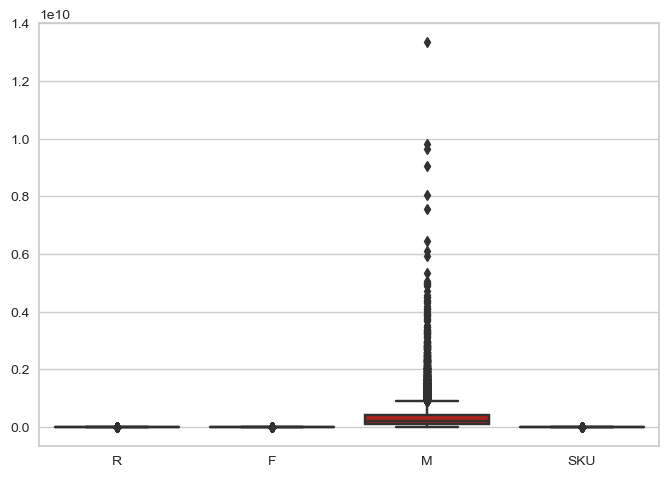

In [45]:
sns.boxplot(data=X)

C:\Users\h.nazari\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='M'>

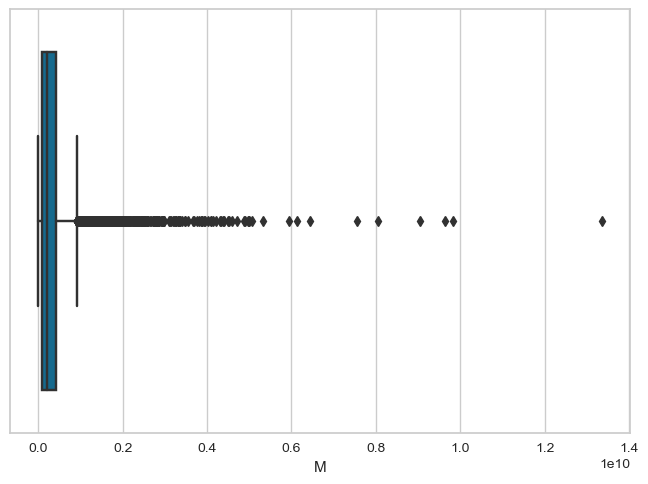

In [46]:
sns.boxplot(X['M'])

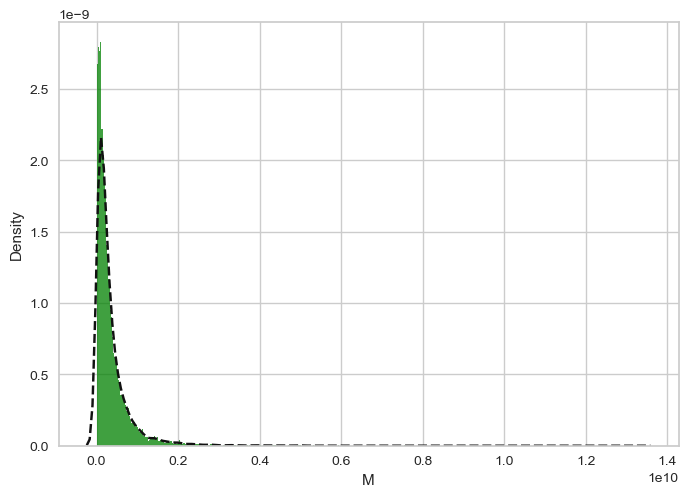

In [47]:
sns.histplot(X['M'],color='green',stat='density',edgecolor='none')
sns.kdeplot(X['M'],color='k',linestyle='--')
plt.show();

In [48]:
#1st method :Zscore

X=X[(np.abs(stats.zscore(X['M']))<5)]

#Put these customers in E cluster
X_low=X[stats.zscore(X['M'])<-5]

#Put these customers in VIP cluster
X_high=X[stats.zscore(X['M'])>5]

In [49]:
X_low.shape,X_high.shape

((0, 4), (65, 4))

In [50]:
# There are 2 other methods to deel with outliers
'''
#2nd method
q = X["M"].quantile(0.99)

q_low = X["M"].quantile(0.01)
q_hi  = X["M"].quantile(0.99)

X_onlyhifiltered=X[X["M"] < q]
X_filtered = X[(X["M"] < q_hi) & (X["M"] > q_low)]
X_low=X[(X['M']<q_low)]
X_hi=X[(X['M']>q_hi)]


#3rd method
q1=X['M'].quantile(0.25)
q3=X['M'].quantile(0.75)
IQR=q3-q1
low_range=q1-1.5*IQR
high_range=q3+1.5*IQR

X_low_range=X[X['M']<low_range]
X_high_range=X[X['M']>high_range]
'''

'\n#2nd method\nq = X["M"].quantile(0.99)\n\nq_low = X["M"].quantile(0.01)\nq_hi  = X["M"].quantile(0.99)\n\nX_onlyhifiltered=X[X["M"] < q]\nX_filtered = X[(X["M"] < q_hi) & (X["M"] > q_low)]\nX_low=X[(X[\'M\']<q_low)]\nX_hi=X[(X[\'M\']>q_hi)]\n\n\n#3rd method\nq1=X[\'M\'].quantile(0.25)\nq3=X[\'M\'].quantile(0.75)\nIQR=q3-q1\nlow_range=q1-1.5*IQR\nhigh_range=q3+1.5*IQR\n\nX_low_range=X[X[\'M\']<low_range]\nX_high_range=X[X[\'M\']>high_range]\n'

# Customer Segmentation

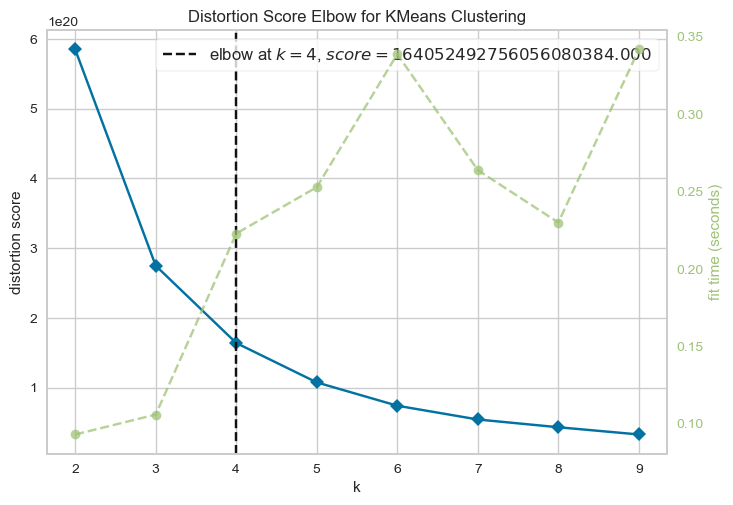

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(2, 10))

In [51]:
kelbow_visualizer(KMeans(), X, k=(2,10))

Text(0, 0.5, 'Within Sum of Squares Distance')

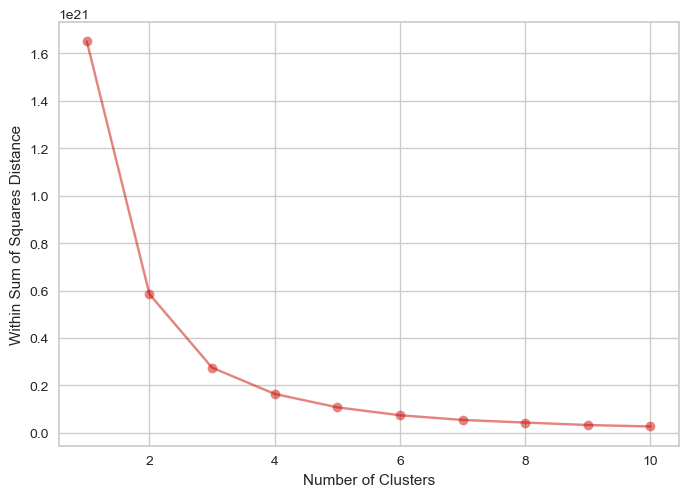

In [52]:
wss=[]

for n in range(1,11):
 kmeans = KMeans(n_clusters=n).fit(X)
 wss.append(kmeans.inertia_)
 
plt.plot(range(1,11),wss,c='r',marker='o',alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Sum of Squares Distance')

In [53]:
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters).fit(X)

pd.DataFrame(kmeans.cluster_centers_,columns=X.columns)


labels=kmeans.labels_
X['clusters']=labels

In [54]:
average_silhouette=silhouette_score(X,labels)
print(average_silhouette)

0.6107513837257169


In [55]:
sample_silhouette_values=silhouette_samples(X,labels)
np.sum(sample_silhouette_values<0)/len(sample_silhouette_values)

0.00044980208708168405

In [56]:
X.groupby('clusters').agg('count')

,R,F,M,SKU
clusters,,,,
0,354,354,354,354
1,6643,6643,6643,6643
2,1131,1131,1131,1131
3,2988,2988,2988,2988


In [57]:
X.groupby('clusters').agg('mean')

,R,F,M,SKU
clusters,,,,
0,11.703390,21.254237,1.840177e+09,99.392655
1,33.714737,7.071052,1.157005e+08,32.885744
2,10.627763,18.425287,8.900085e+08,84.066313
3,14.663989,13.701138,4.100155e+08,63.141232


# Conclusion:
* 0 : VIP
* 2 : A
* 3 : B
* 1 : C

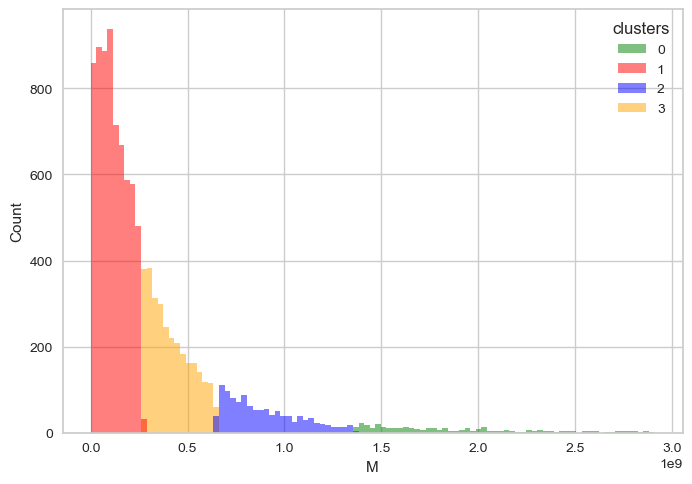

In [59]:
sns.histplot(data=X,x='M',hue='clusters',edgecolor='none',palette=['green','red','blue','orange']);

# It doesn't make sense that 60% of our customer get the lowest grade. That would be because the data set is not scaled and features need to be scaled. Actually, the model tend to consider M as a most important featue in compared to others.

# Try With Scaled data

In [60]:
#With Scale
X=pd.concat((pd.DataFrame(Recency),pd.DataFrame(Frequency),pd.DataFrame(Montery),pd.DataFrame(SKU)),axis=1)
X.columns=['R','F','M',"SKU"]
X=X.loc[X['M']>0,:]
X=X[(np.abs(stats.zscore(X['M']))<5)]

standardize=StandardScaler()
standardize.fit(X)
X=standardize.fit_transform(X)

X=pd.DataFrame(X)
X.columns=['R','F','M',"SKU"]
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters).fit(X)

pd.DataFrame(kmeans.cluster_centers_,columns=X.columns)

,R,F,M,SKU
0,-0.434524,0.610351,0.206999,0.584287
1,2.506099,-0.959042,-0.558153,-0.882920
2,-0.157384,-0.536171,-0.460029,-0.543645
3,-0.481282,1.726795,2.358206,1.774993


In [61]:
Xorg=standardize.inverse_transform(X)
Xorg=pd.DataFrame(Xorg)
Xorg.columns=[ 'R', 'F', 'M','SKU']
Xorg['clusters']=kmeans.labels_
Xorg.index=X.index
Xorg.groupby('clusters').count()

,R,F,M,SKU
clusters,,,,
0,3688,3688,3688,3688
1,1162,1162,1162,1162
2,5283,5283,5283,5283
3,983,983,983,983


In [62]:
Xorg.groupby('clusters').agg('mean')

,R,F,M,SKU
clusters,,,,
0,9.105206,15.139371,4.081776e+08,67.573753
1,120.255594,3.104131,1.134722e+08,19.265921
2,19.573159,6.347341,1.512534e+08,30.433844
3,7.348932,23.703967,1.236482e+09,106.825025


# Conclusion:
* 3 : VIP
* 0 : A
* 2 : B
* 1 : C

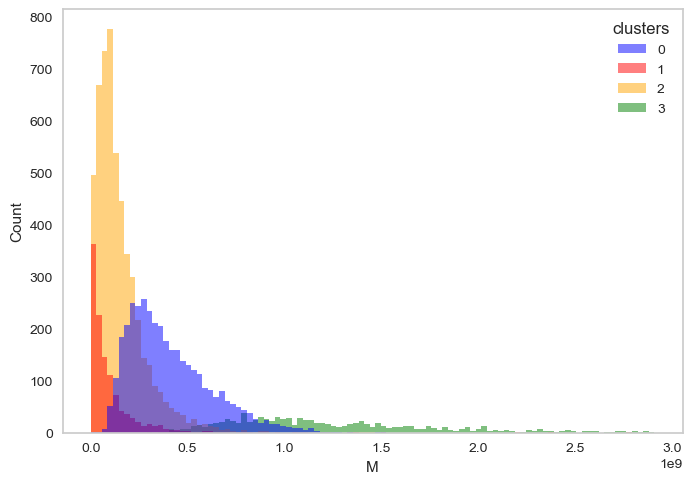

In [64]:
sns.histplot(data=Xorg,x='M',hue='clusters',edgecolor='none',palette=['blue','red','orange','green'])
plt.grid();

In [39]:
fig = px.scatter_3d(Xorg,x='R',y='F',z='M',size='SKU', color='clusters')

fig.update_layout(width=800, height=800, title = 'Customers Clusters',
                  scene = dict(xaxis=dict(title='Recency', titlefont_color='darkblue'),
                               yaxis=dict(title='Frequency', titlefont_color='darkblue'),
                               zaxis=dict(title='Monetary Value', titlefont_color='darkblue'),
                               bgcolor = 'lightblue'
                           ))
fig.show()
fig.write_html("Downloads/CustomersClusters.html")

In [41]:
fig = px.parallel_coordinates(Xorg, color="clusters",
                              dimensions=['R','F','M','SKU'],
                             color_continuous_midpoint=2)

fig.show()

In [40]:
#save it as a csv file
Xorg.to_csv('E:/GRADECUSTOMER/1401/RFMSKU_new.csv')